In [1]:
# # colab
# import os
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/light beam')

In [2]:
import math
import pydicom
import numpy as np 
from scipy import ndimage
import matplotlib.pyplot as plt

In [3]:
# dicom_file_path = 'images\DICOMOBJ\'
arrays = []
dicom_file_path = 'images/DICOMOBJ/9x7-L'
is_rotate = False

# Read the DICOM file
dicom_data = pydicom.dcmread(dicom_file_path)
arr = dicom_data.pixel_array
if is_rotate :
    arr = ndimage.rotate(arr, 90)
h, w = arr.shape
h, w

(2208, 2688)

In [4]:
# optimize pixel value to range 0-255
max_pixel_val = arr.max()
arr = (arr/max_pixel_val)*255

In [5]:
def display(arr, axis=False) :
    plt.imshow(arr, cmap="gray")
    plt.axis(axis)

In [6]:
def inv_lut(arr) :
    max_p = arr.max()
    min_p = arr.min()
    return max_p - arr + min_p

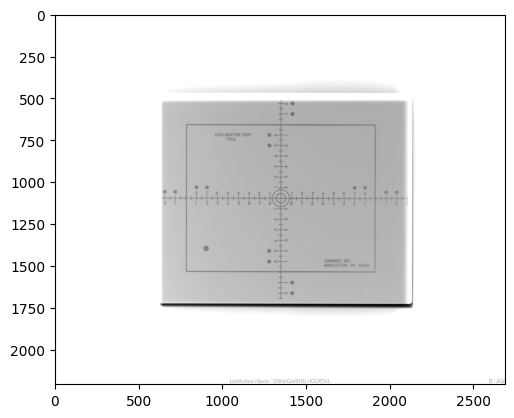

In [7]:
display(arr, True)

### Find light-beam bar

In [8]:
# assume crop if each size > 2,000 (not crop yet)
h, w = arr.shape
p = 0.24 # experimental number
if (h*w) > (2000**2) :
    arr = arr[int(h*p): int(h*(1-p)), int(w*p): int(w*(1-p))]
    h, w = arr.shape

In [9]:
display(arr, True)

### Find details in full field image
- Centerline and angle for rotating the image to the axis.
- Center point.
- Rectangular field.
- Ratio to convert the number of pixels to centimeters.

In [10]:
def find_common_value(focus_arr, axis=0) :
    """
    find common value of each row or colume
    agrs: axis=0 - col, axis=1 - row
    return: most common pixel value
    """
    vals = np.argmin(focus_arr, axis=axis) #[b, w] color
    unique_elements, counts = np.unique(vals, return_counts=True)
    most_common_index = np.argmax(counts)
    val = unique_elements[most_common_index]
    return val

In [11]:
hp = int(0.15*h) # crop ratio
wp = int(0.05*w)

#left point
focus_l = arr[hp: h-hp, wp: wp*2]
vals = np.argmin(focus_l, axis=0) #[b, w] color
unique_elements, counts = np.unique(vals, return_counts=True)
most_common_index = np.argmax(counts)
val = unique_elements[most_common_index]
val, counts

(397,
 array([ 1,  2,  3,  2,  1,  3,  1,  1,  1,  1,  1,  1, 22, 27,  2],
       dtype=int64))

In [12]:
vals

array([358, 358, 352, 353, 351, 364, 353, 353, 352, 354, 354, 362, 356,
       359, 358, 397, 397, 396, 396, 396, 396, 396, 397, 396, 396, 396,
       397, 397, 397, 396, 396, 397, 396, 396, 397, 389, 403, 390, 397,
       396, 396, 397, 397, 397, 397, 396, 397, 396, 396, 396, 396, 396,
       396, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397,
       397, 396, 391, 403], dtype=int64)

In [13]:
unique_elements, counts

(array([351, 352, 353, 354, 356, 358, 359, 362, 364, 389, 390, 391, 396,
        397, 403], dtype=int64),
 array([ 1,  2,  3,  2,  1,  3,  1,  1,  1,  1,  1,  1, 22, 27,  2],
       dtype=int64))

In [14]:
def find_center_line(arr: np.array, visualize=True) :
    """
    find horizontal center line
    Return: (x1, y1), (x2, y2)
    """
    h, w = arr.shape
    hp = int(0.15*h) # crop ratio
    wp = int(0.05*w)

    #left point
    focus_l = arr[hp: h-hp, wp: wp*2]
    y1 = find_common_value(focus_l, axis=0) + hp # because focus start at hp not 0

    #Right point
    focus_r = arr[hp: h-hp, w-(wp*2): w-wp]
    y2 = find_common_value(focus_r, axis=0) + hp 

    if visualize :
        plt.figure(figsize=(3, 6))
        plt.subplot(1, 2, 1)
        display(focus_l, axis=True)
        plt.tick_params(bottom=False, labelbottom=False) # hide x-axis

        plt.subplot(1, 2, 2)
        display(focus_r, axis=True)
        plt.tick_params(bottom=False, labelbottom=False)
        plt.suptitle(f"Center line is on \n{y1-hp} and {y2-hp} [y-axis]") # re-axis same as croped

    return (0, y1), (w, y2)

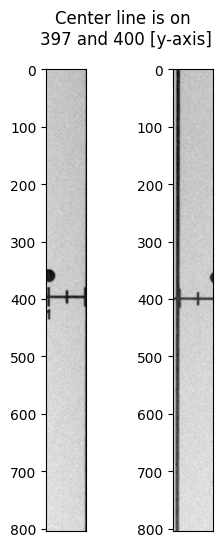

In [15]:
(x1, y1), (x2, y2) = find_center_line(arr)

In [16]:
(x1, y1), (x2, y2)

((0, 569), (1397, 572))

In [17]:
def draw_line(arr, x1, y1, x2, y2, axis=False) :
    plt.imshow(arr, cmap="gray")
    plt.plot([x1, x2], [y1, y2], color='blue', linewidth=1)
    plt.axis(axis)

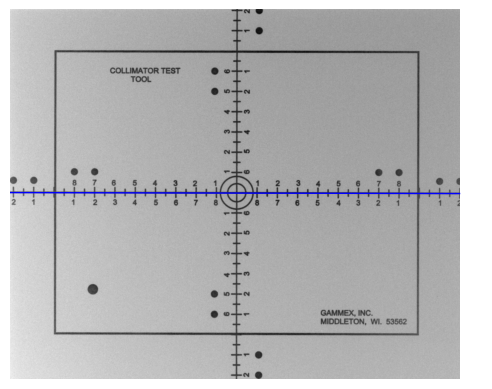

In [18]:
draw_line(arr, x1, y1, x2, y2)

In [19]:
def find_theta(w, y1, y2) :
    """
    find theta from y1, y2
    Return: theta in degree
    """
    a = y2-y1
    theta_r = math.atan(a/w)
    theta_d = math.degrees(theta_r)
    return theta_d

In [20]:
theta_d = find_theta(w, y1, y2)
theta_d

0.12304013909515928

In [21]:
# CCW rotate
rotate_img = ndimage.rotate(arr, theta_d, reshape=False, cval=arr.max())
rotate_img = rotate_img.astype(np.uint8)
h, w = rotate_img.shape

arrays.append(rotate_img)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Original")
display(arr)

plt.subplot(1, 2, 2)
plt.title(f"Rotated : {theta_d:.2f} deg")
display(rotate_img)

In [22]:
#find horizontal lines[y-axis]
def find_horizontal_line(arr: np.array):
    """
    Return: (top(y1, y2), center(y1, y2), bottom(y1, y2))
    """
    ypoints = []
    h, w = arr.shape
    hp = int(0.27*h) # crop ratio
    wp = int(0.07*w)

    # top line
    focus_l = arr[: hp, wp*2: wp*3]
    y1 = find_common_value(focus_l, axis=0)
    focus_r = arr[: hp, w-(wp*3): w-(wp*2)]
    y2 = find_common_value(focus_l, axis=0)
    ypoints.append((y1, y2))

    #center line
    (_, y1), (_, y2) = find_center_line(arr, visualize=False)
    ypoints.append((y1, y2))

    # bottom line
    focus_l = arr[h-hp: , wp*2: wp*3]
    y1 = find_common_value(focus_l, axis=0) + h-hp
    focus_r = arr[h-hp: , w-(wp*3): w-(wp*2)]
    y2 = find_common_value(focus_r, axis=0) + h-hp
    ypoints.append((y1, y2))

    return ypoints, focus_r

In [23]:
ypoints, r = find_horizontal_line(rotate_img)
ypoints

[(132, 132), (570, 570), (1007, 1009)]

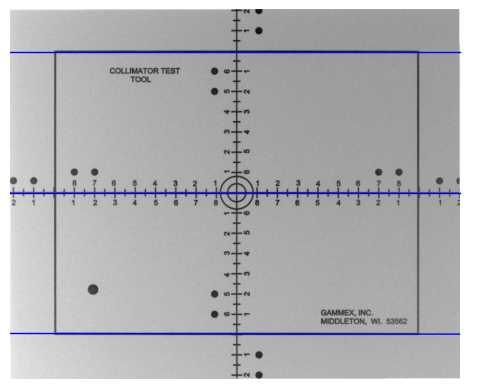

In [24]:
for idx in range(len(ypoints)) : 
    draw_line(rotate_img, 0, ypoints[idx][0], w, ypoints[idx][1])

In [25]:
#find vertical lines[x-axis]
def find_vertical_line(arr: np.array):
    """
    Return: (top(x1, x2), center(x1, x2), bottom(x1, x2))
    """
    xpoints = []
    h, w = arr.shape
    hp = int(0.05*h) # crop ratio
    wp = int(0.04*w)

    # left line
    focus_t = arr[hp*3: hp*7, wp: wp*6]
    x1 = find_common_value(focus_t, axis=1) + wp
    focus_b = arr[h-hp*7: h-hp*3, wp: wp*6]
    x2 = find_common_value(focus_b, axis=1) + wp
    xpoints.append((x1, x2))

    # right line
    focus_t = arr[hp*3: hp*7, w-(wp*6): w-wp]
    x1 = find_common_value(focus_t, axis=1) + w-(wp*6)
    focus_b = arr[h-hp*7: h-hp*3, w-(wp*6): w-wp]
    x2 = find_common_value(focus_b, axis=1) + w-(wp*6)
    xpoints.append((x1, x2))

    #center line
    hp = int(0.18*h)
    wp = int(0.2*w)

    focus_t = arr[hp: hp*2, wp*2: wp*3]
    x1 = find_common_value(focus_t, axis=1) + (wp*2)
    focus_b = arr[h-(hp*2): h-hp, wp*2: wp*3]
    x2 = find_common_value(focus_b, axis=1) + (wp*2)
    xpoints.append((x1, x2))

    # swap bottom and center in xpoints
    centerpoints = xpoints[-1]
    xpoints[-1] = xpoints[1]
    xpoints[1] = centerpoints
    return xpoints

In [26]:
xpoints = find_vertical_line(rotate_img)
xpoints

[(139, 141), (703, 703), (1266, 1266)]

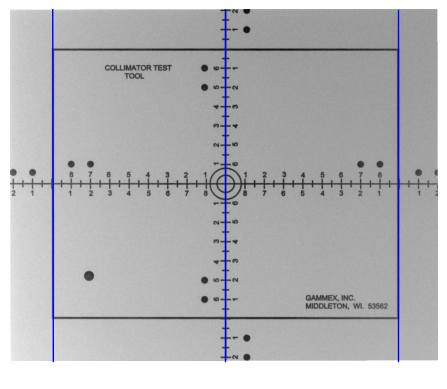

In [27]:
for idx in range(len(xpoints)) : 
    draw_line(rotate_img, xpoints[idx][0], 0, xpoints[idx][1], h)

In [28]:
xpoints = [round(np.mean(xpoints[idx])) for idx in range(3)]
ypoints = [round(np.mean(ypoints[idx])) for idx in range(3)]
xpoints, ypoints

([140, 703, 1266], [132, 570, 1008])

In [29]:
for idx in range(len(ypoints)) : 
    draw_line(rotate_img, xpoints[idx], 0, xpoints[idx], h)
    draw_line(rotate_img, 0, ypoints[idx], w, ypoints[idx])

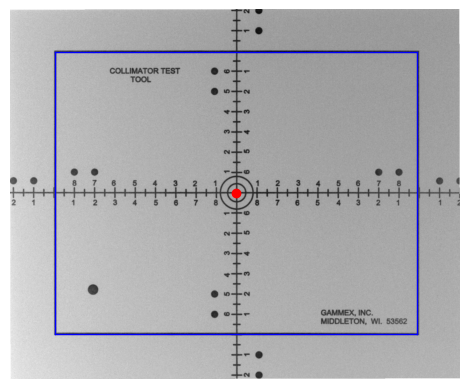

In [30]:
for idx in range(len(ypoints)) : 
    draw_line(rotate_img, xpoints[idx], ypoints[idx], xpoints[idx], ypoints[-idx-1])
    draw_line(rotate_img, xpoints[idx], ypoints[idx], xpoints[-idx-1], ypoints[idx])
plt.plot((xpoints[1]), (ypoints[1]), 'o', color="red")

In [31]:
print(f"9cm [horizontal] equal: {xpoints[2] - xpoints[1]} pixels")
print(f"7cm [vertical] equal: {ypoints[2] - ypoints[1]} pixels")

9cm [horizontal] equal: 563 pixels
7cm [vertical] equal: 438 pixels


In [32]:
def pixel2cm(number_pixel: int, is_rotate) :
    """
    convert number of pixel to centimeter as aspect ratio
    """
    _cm = ypoints[2] - ypoints[1]
    ratio = 7
    if is_rotate :
        ratio = 9
    return round(number_pixel*ratio/_cm, 2)

In [33]:
pixel2cm(438, is_rotate)

7.0

### 9x7cm

In [34]:
dicom_file_path = 'images/DICOMOBJ/9x7'

# Read the DICOM file
dicom_data = pydicom.dcmread(dicom_file_path)
arr = dicom_data.pixel_array
# optimize pixel value to range 0-255
max_pixel_val = arr.max()
arr = (arr/max_pixel_val)*255
if is_rotate :
    arr = ndimage.rotate(arr, 90)

h, w = arr.shape

# assume crop if each size > 2,000 (not crop yet)
p = 0.24 # experimental number
if (h*w) > (2000**2) :
    arr = arr[int(h*p): int(h*(1-p)), int(w*p): int(w*(1-p))]
    h, w = arr.shape

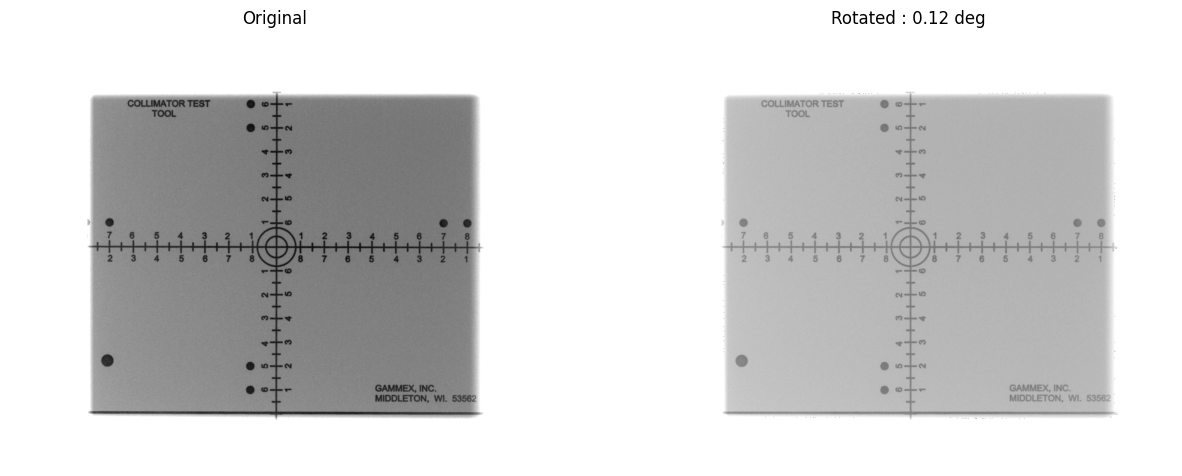

In [35]:
rotate_img = ndimage.rotate(arr, theta_d, reshape=False, cval=arr.max())
rotate_img = rotate_img.astype(np.uint8)

arrays.append(rotate_img)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Original")
display(arr)

plt.subplot(1, 2, 2)
plt.title(f"Rotated : {theta_d:.2f} deg")
display(rotate_img)

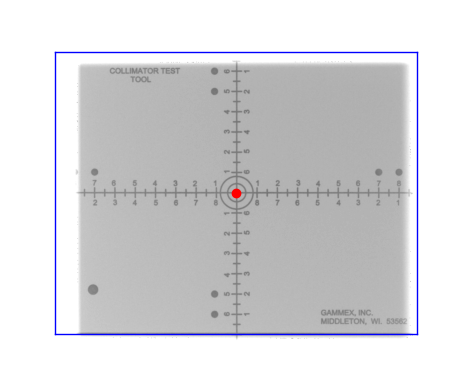

In [36]:
for idx in range(len(ypoints)) : 
    draw_line(rotate_img, xpoints[idx], ypoints[idx], xpoints[idx], ypoints[-idx-1])
    draw_line(rotate_img, xpoints[idx], ypoints[idx], xpoints[-idx-1], ypoints[idx])
plt.plot((xpoints[1]), (ypoints[1]), 'o', color="red")

### Find difference between bouding box and actual area

In [37]:
xpoints, ypoints

([140, 703, 1266], [132, 570, 1008])

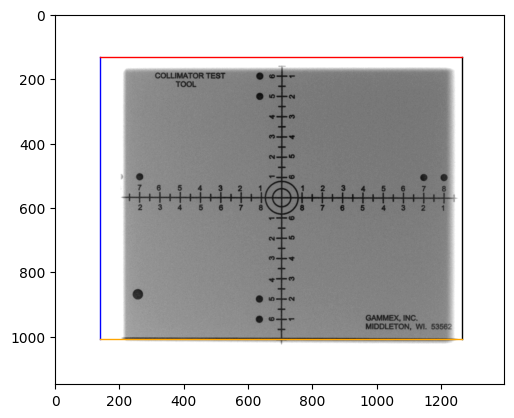

In [38]:
plt.imshow(arr, cmap="gray")
plt.plot([xpoints[0], xpoints[0]], [ypoints[0], ypoints[2]], color='blue', linewidth=1)
plt.plot([xpoints[2], xpoints[2]], [ypoints[0], ypoints[2]], color='k', linewidth=1)
plt.plot([xpoints[0], xpoints[2]], [ypoints[0], ypoints[0]], color='red', linewidth=1)
plt.plot([xpoints[0], xpoints[2]], [ypoints[2], ypoints[2]], color='orange', linewidth=1)

In [39]:
# find y1 distance[left]
center_p = xpoints[1], ypoints[1]
left_point = xpoints[0], ypoints[1]
center_p, left_point

((703, 570), (140, 570))

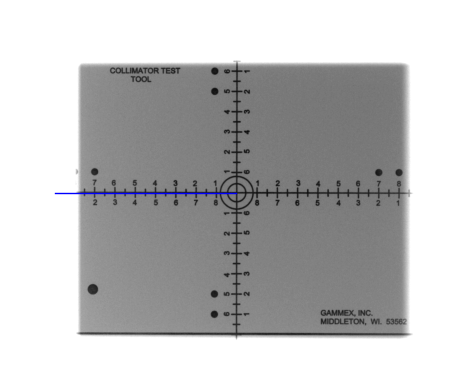

In [40]:
draw_line(arr, center_p[0], center_p[1], left_point[0], left_point[1])

Left crop

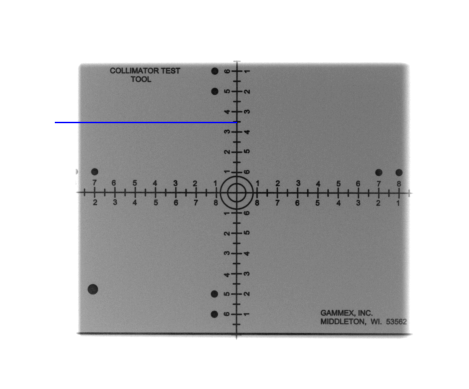

In [41]:
# estimate line between top and center: to escepe center black line
center_p = xpoints[1], (ypoints[0] + ypoints[1])//2
left_p = xpoints[0], (ypoints[0]+ypoints[1])//2
draw_line(arr, center_p[0], center_p[1], left_p[0], left_p[1])

In [42]:
crop_ratio = 0.2
add_horizontal_crop = int((left_p[0]*(1-crop_ratio)) + (center_p[0]*crop_ratio)) - left_p[0]
add_vertical_crop = int(h*0.04)
add_horizontal_crop, add_vertical_crop

(112, 45)

In [43]:
top_left_point = max(left_p[0]-add_horizontal_crop, 0), left_p[1]-add_vertical_crop  # prevent negative 
bottom_right_point = left_p[0]+add_horizontal_crop, left_p[1]+add_vertical_crop
top_left_point, bottom_right_point

((28, 306), (252, 396))

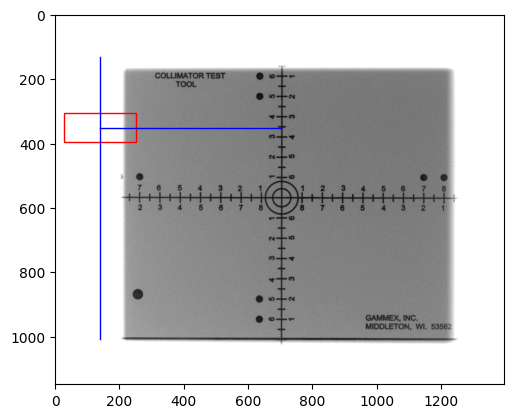

In [44]:
# crop left area
from matplotlib.patches import Rectangle

ax = plt.gca()
display(arr, True)
(x, y), w, h = top_left_point, bottom_right_point[0]-top_left_point[0], bottom_right_point[1]-top_left_point[1]
plt.plot([xpoints[0], xpoints[0]], [ypoints[0], ypoints[2]], color='blue', linewidth=1)
plt.plot([center_p[0], left_p[0]], [center_p[1], left_p[1]], color='blue', linewidth=1)
rect = Rectangle((x, y), w, h, linewidth=1, edgecolor='r',facecolor='none')
ax.add_patch(rect)

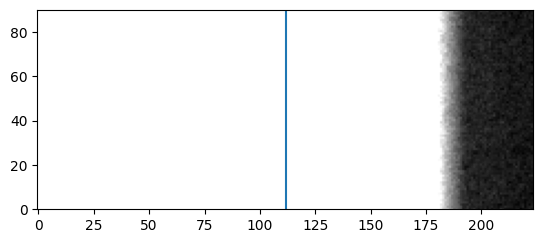

In [45]:
left_focus = arr[top_left_point[1]: bottom_right_point[1], top_left_point[0]: bottom_right_point[0]]
display(left_focus, True)
plt.plot([xpoints[0]-top_left_point[0], xpoints[0]-top_left_point[0]], [0, bottom_right_point[1]-top_left_point[1]])
plt.ylim([0, bottom_right_point[1]-top_left_point[1]]);

In [46]:
def first_white(arr, by_col, position) :
    # TODO: find idx that first white then -1 for actually area
    nrows, ncols = arr.shape
    white_pixel_val = arr.max()
    first_val_idx = []
    black_pos = ["right", "bottom"]
    is_black = position in black_pos
    if is_black :
        # right and bottom : start from last col and row
        if by_col :
            for row in range(nrows) :
                for col in range(ncols) :
                    pixel_val = arr[nrows-1-row][ncols-1-col]
                    if pixel_val < white_pixel_val :
                        first_val_idx.append(ncols-col)
                        break
        else :
            for col in range(ncols) :
               for row in range(nrows) :
                    pixel_val = arr[nrows-1-row][ncols-1-col]
                    if pixel_val < white_pixel_val :
                        first_val_idx.append(nrows-row)
                        break  
    else :
        # left and top
        if by_col :
            for row in range(nrows) :
                for col in range(ncols) :
                    pixel_val = arr[row][col]
                    if pixel_val < white_pixel_val :
                        first_val_idx.append(col-1) # back to real white position
                        break
        else :
            for col in range(ncols) :
                for row in range(nrows) :
                    pixel_val = arr[row][col]
                    if pixel_val < white_pixel_val :
                        first_val_idx.append(row-1)
                        break

    unique_elements, counts = np.unique(first_val_idx, return_counts=True)
    most_common_index = np.argmax(counts)
    idx = unique_elements[most_common_index]
    return idx

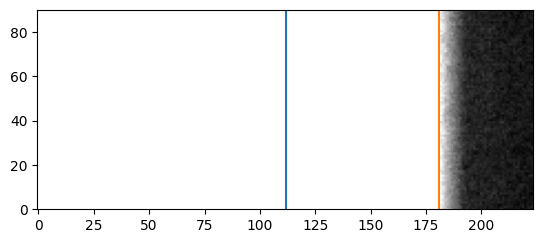

In [47]:
left_focus = arr[top_left_point[1]: bottom_right_point[1], top_left_point[0]: bottom_right_point[0]]
first_white_left = first_white(left_focus, by_col=True, position="left")
display(left_focus, True)
plt.plot([xpoints[0]-top_left_point[0], xpoints[0]-top_left_point[0]], [0, bottom_right_point[1]-top_left_point[1]])
plt.plot([first_white_left, first_white_left], [0, bottom_right_point[1]-top_left_point[1]])
plt.ylim([0, bottom_right_point[1]-top_left_point[1]]);

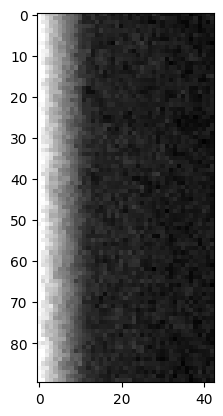

In [48]:
left_find_black = left_focus[:, first_white_left:]
display(left_find_black, True)

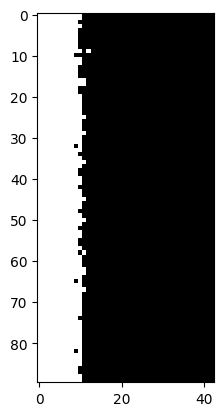

In [49]:
cut_off = left_find_black.mean()
binary_arr = (left_find_black > cut_off)*1
display(binary_arr, True)

In [50]:
last_white_left = first_white(binary_arr, by_col=True, position="left") + first_white_left
first_white_left, last_white_left

(181, 191)

### bte_pos: between the edge

In [51]:
res = []
# bte_pos(x1, x2, y1, y2), length, error

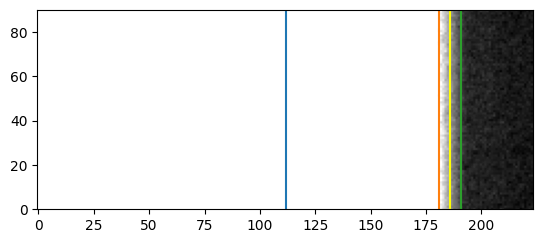

In [52]:
left_focus = arr[top_left_point[1]: bottom_right_point[1], top_left_point[0]: bottom_right_point[0]]
display(left_focus, True)
plt.plot([xpoints[0]-top_left_point[0], xpoints[0]-top_left_point[0]], [0, bottom_right_point[1]-top_left_point[1]])
plt.plot([first_white_left, first_white_left], [0, bottom_right_point[1]-top_left_point[1]])
plt.plot([last_white_left, last_white_left], [0, bottom_right_point[1]-top_left_point[1]])
bte_pos = (first_white_left + last_white_left) //2
plt.plot([bte_pos, bte_pos], [0, bottom_right_point[1]-top_left_point[1]], c="yellow")
plt.ylim([0, bottom_right_point[1]-top_left_point[1]]);

In [53]:
# def argdiffs(arr, by_col=True) :
#     """ 
#     find most difference value by coloumn or row
    
#     Return :
#         most difference idx
#     """
#     nrows, ncols = arr.shape
#     max_diffs = []
#     if by_col :
#         for r in range(nrows) :
#             max_diff = 0
#             max_diff_idx = 0
#             for c in range(ncols-1) :
#                 cur_val = arr[r][c]
#                 next_val = arr[r][c+1]
#                 diff = abs(int(cur_val)-int(next_val))
#                 if diff > max_diff :
#                     max_diff = diff 
#                     max_diff_idx = c
#             max_diffs.append(max_diff_idx)
#     else :
#         for c in range(ncols) :
#             max_diff = 0
#             max_diff_idx = 0
#             for r in range(nrows-1) :
#                 cur_val = arr[r][c]
#                 next_val = arr[r+1][c]
#                 diff = abs(int(cur_val)-int(next_val))
#                 if diff > max_diff :
#                     max_diff = diff 
#                     max_diff_idx = r
#             max_diffs.append(max_diff_idx)

#     unique_elements, counts = np.unique(max_diffs, return_counts=True)
#     most_common_index = np.argmax(counts)
#     val = unique_elements[most_common_index]
#     return val

In [54]:
xpoints[0]-top_left_point[0], bte_pos

(112, 186)

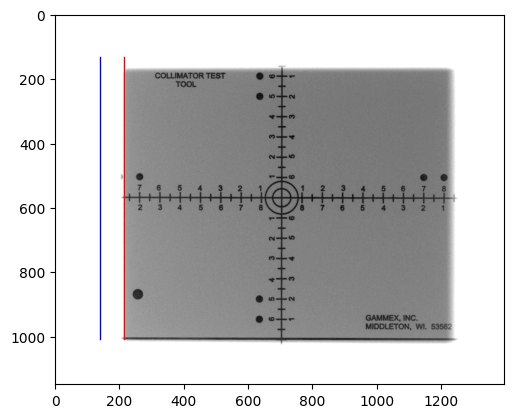

In [55]:
display(arr, True)
plt.plot([xpoints[0], xpoints[0]], [ypoints[0], ypoints[2]], color='blue', linewidth=1)
bte_pos = bte_pos + top_left_point[0] # to reset position same as large arr
plt.plot([bte_pos, bte_pos], [ypoints[0], ypoints[2]], color='red', linewidth=1)

In [56]:
xpoints[1]-xpoints[0], bte_pos

(563, 214)

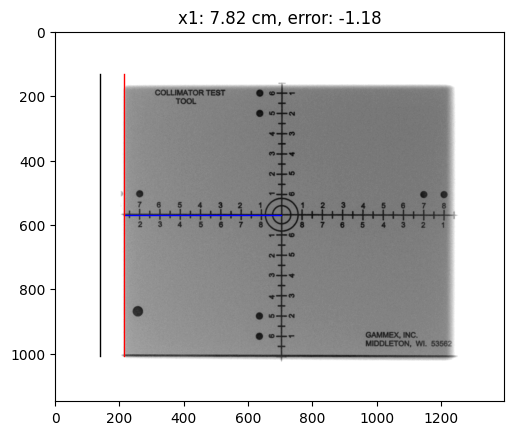

In [57]:
draw_line(arr, bte_pos, ypoints[1], xpoints[1], ypoints[1], True)
plt.plot([bte_pos, bte_pos], [ypoints[0], ypoints[2]], color='red', linewidth=1)
plt.plot([xpoints[0], xpoints[0]], [ypoints[0], ypoints[2]], color='k', linewidth=1)
length_x1 = pixel2cm(xpoints[1] - bte_pos, is_rotate)
legth_diff = pixel2cm((xpoints[1] - bte_pos) - (xpoints[1]-xpoints[0]), is_rotate)
plt.title(f"x1: {length_x1:.2f} cm, error: {legth_diff:.2f}");

In [58]:
res.append([bte_pos, bte_pos, ypoints[0], ypoints[2], length_x1, legth_diff])

Right Crop

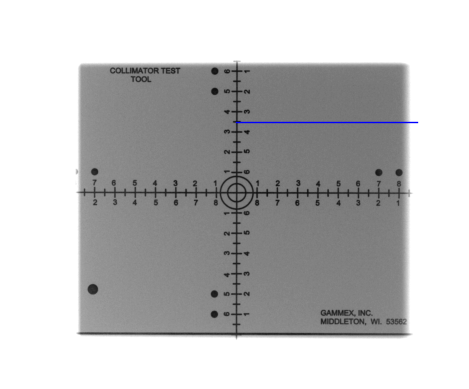

In [59]:
# estimate line between top and center: to escepe center black line
center_p = xpoints[1], (ypoints[0] + ypoints[1])//2
right_p = xpoints[2], (ypoints[0]+ypoints[1])//2
draw_line(arr, center_p[0], center_p[1], right_p[0], right_p[1])

In [60]:
top_left_point = right_p[0]-add_horizontal_crop, right_p[1]-add_vertical_crop  
bottom_right_point = right_p[0]+add_horizontal_crop, right_p[1]+add_vertical_crop
top_left_point, bottom_right_point

((1154, 306), (1378, 396))

In [61]:
ax = plt.gca()
display(arr, True)
(x, y), w, h = top_left_point, bottom_right_point[0]-top_left_point[0], bottom_right_point[1]-top_left_point[1]
plt.plot([xpoints[2], xpoints[2]], [ypoints[0], ypoints[2]], color='blue', linewidth=1)
plt.plot([center_p[0], right_p[0]], [center_p[1], right_p[1]], color='blue', linewidth=1)
rect = Rectangle((x, y), w, h, linewidth=1, edgecolor='r',facecolor='none')
ax.add_patch(rect)

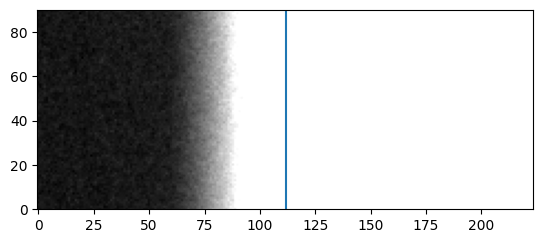

In [62]:
right_focus = arr[top_left_point[1]: bottom_right_point[1], top_left_point[0]: bottom_right_point[0]]
display(right_focus, True)
plt.plot([xpoints[2]-top_left_point[0], xpoints[2]-top_left_point[0]], [0, bottom_right_point[1]-top_left_point[1]])
plt.ylim([0, bottom_right_point[1]-top_left_point[1]]);

In [63]:
first_white_right = first_white(right_focus, by_col=True, position="right")
display(right_focus, True)
plt.plot([xpoints[2]-top_left_point[0], xpoints[2]-top_left_point[0]], [0, bottom_right_point[1]-top_left_point[1]])
plt.plot([first_white_right, first_white_right], [0, bottom_right_point[1]-top_left_point[1]])
plt.ylim([0, bottom_right_point[1]-top_left_point[1]]);

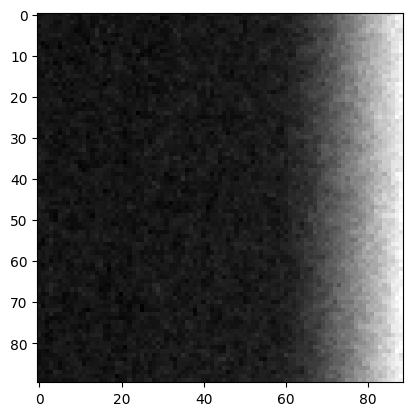

In [64]:
right_find_black = right_focus[:, :first_white_right]
display(right_find_black, True)

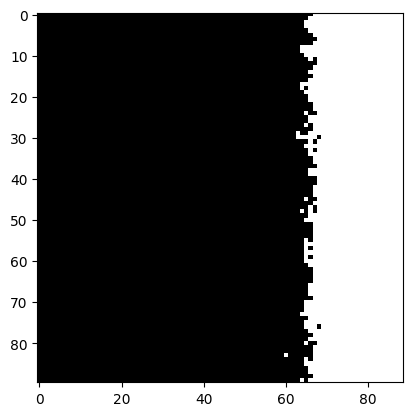

In [65]:
cut_off = right_find_black.mean()
binary_arr = (right_find_black > cut_off)*1
display(binary_arr, True)

In [66]:
last_white_right = first_white(binary_arr, by_col=True, position="right")
first_white_right, last_white_right

(89, 67)

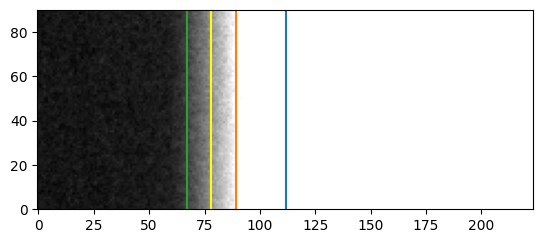

In [67]:
display(right_focus, True)
plt.plot([xpoints[2]-top_left_point[0], xpoints[2]-top_left_point[0]], [0, bottom_right_point[1]-top_left_point[1]])
plt.plot([first_white_right, first_white_right], [0, bottom_right_point[1]-top_left_point[1]])
plt.plot([last_white_right, last_white_right], [0, bottom_right_point[1]-top_left_point[1]])
plt.ylim([0, bottom_right_point[1]-top_left_point[1]]);
bte_pos = (first_white_right + last_white_right) //2
plt.plot([bte_pos, bte_pos], [0, bottom_right_point[1]-top_left_point[1]], c="yellow")

In [68]:
bte_pos = bte_pos + top_left_point[0] # to reset position same as large arr

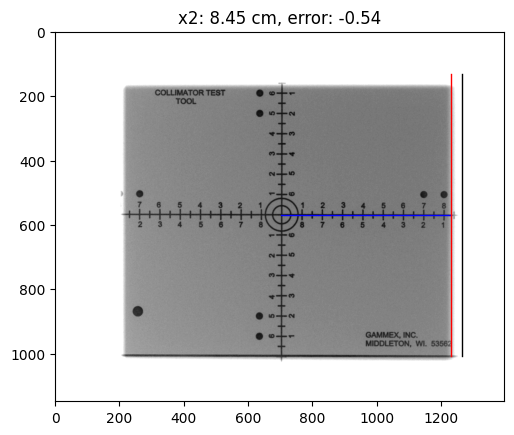

In [69]:
draw_line(arr, bte_pos, ypoints[1], xpoints[1], ypoints[1], True)
plt.plot([bte_pos, bte_pos], [ypoints[0], ypoints[2]], color='red', linewidth=1)
plt.plot([xpoints[2], xpoints[2]], [ypoints[0], ypoints[2]], color='k', linewidth=1)
length_x2 = pixel2cm(bte_pos - xpoints[1], is_rotate)
legth_diff = pixel2cm((bte_pos - xpoints[1]) - (xpoints[2]-xpoints[1]), is_rotate)
plt.title(f"x2: {length_x2:.2f} cm, error: {legth_diff:.2f}");

In [70]:
res.append([bte_pos, bte_pos, ypoints[0], ypoints[2], length_x2, legth_diff])

Top crop

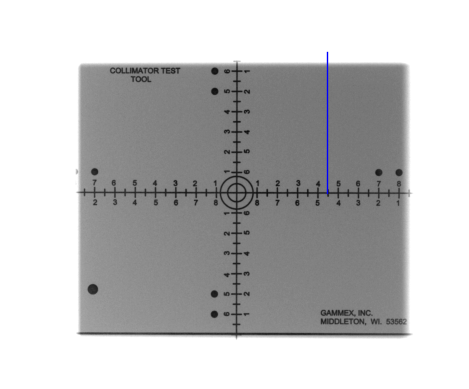

In [71]:
# estimate line between top and center: to escepe center black line
center_p = (xpoints[1]+xpoints[2])//2, ypoints[1]
top_p = (xpoints[1]+xpoints[2])//2, ypoints[0]
draw_line(arr, center_p[0], center_p[1], top_p[0], top_p[1])

In [72]:
top_left_point = top_p[0]-add_vertical_crop, max(top_p[1]-add_horizontal_crop, 0)
bottom_right_point = top_p[0]+add_vertical_crop, top_p[1]+add_horizontal_crop
top_left_point, bottom_right_point

((939, 20), (1029, 244))

In [73]:
ax = plt.gca()
display(arr, True)
(x, y), w, h = top_left_point, bottom_right_point[0]-top_left_point[0], bottom_right_point[1]-top_left_point[1]
plt.plot([xpoints[0], xpoints[2]], [ypoints[0], ypoints[0]], color='blue', linewidth=1)
plt.plot([center_p[0], top_p[0]], [center_p[1], top_p[1]], color='blue', linewidth=1)
rect = Rectangle((x, y), w, h, linewidth=1, edgecolor='r',facecolor='none')
ax.add_patch(rect)

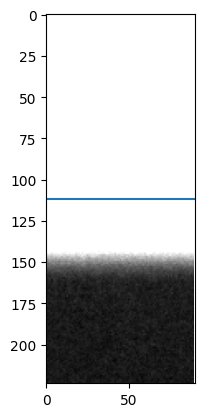

In [74]:
top_focus = arr[top_left_point[1]: bottom_right_point[1], top_left_point[0]: bottom_right_point[0]]
display(top_focus, True)
plt.plot([0, bottom_right_point[0]-top_left_point[0]], [ypoints[0]-top_left_point[1], ypoints[0]-top_left_point[1]])
plt.xlim([0, bottom_right_point[0]-top_left_point[0]]);

In [75]:
first_white_top = first_white(top_focus, by_col=False,  position="top")
display(top_focus, True)
plt.plot([0, bottom_right_point[0]-top_left_point[0]], [ypoints[0]-top_left_point[1], ypoints[0]-top_left_point[1]])
plt.plot([0, bottom_right_point[0]-top_left_point[0]], [first_white_top, first_white_top])
plt.xlim([0, bottom_right_point[0]-top_left_point[0]]);

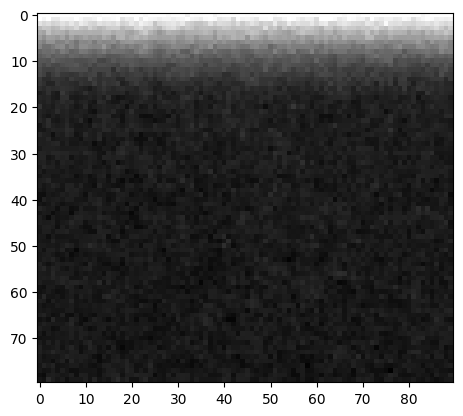

In [76]:
top_find_black = top_focus[first_white_top:, :]
display(top_find_black, True)

In [77]:
cut_off = top_find_black.mean()
binary_arr = (top_find_black > cut_off)*1
display(binary_arr, True)

In [78]:
last_white_top = first_white(binary_arr, by_col=False, position="top") + first_white_top
first_white_top, last_white_top

(144, 158)

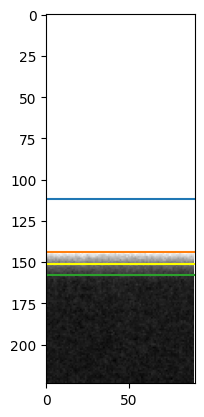

In [79]:
display(top_focus, True)
plt.plot([0, bottom_right_point[0]-top_left_point[0]], [ypoints[0]-top_left_point[1], ypoints[0]-top_left_point[1]])
plt.plot([0, bottom_right_point[0]-top_left_point[0]], [first_white_top, first_white_top])
plt.plot([0, bottom_right_point[0]-top_left_point[0]], [last_white_top, last_white_top])
bte_pos = (first_white_top + last_white_top) //2
plt.plot([0, bottom_right_point[0]-top_left_point[0]], [bte_pos, bte_pos], c="yellow")
plt.xlim([0, bottom_right_point[0]-top_left_point[0]]);

In [80]:
bte_pos = bte_pos + top_left_point[1] # to reset position same as large arr

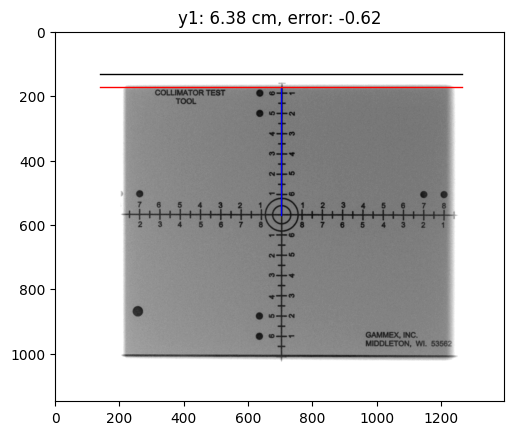

In [81]:
draw_line(arr, xpoints[1], bte_pos, xpoints[1], ypoints[1], True)
plt.plot([xpoints[0], xpoints[2]], [bte_pos, bte_pos], color='red', linewidth=1)
plt.plot([xpoints[0], xpoints[2]], [ypoints[0], ypoints[0]], color='k', linewidth=1)
length_y1 = pixel2cm(ypoints[1] - bte_pos, is_rotate)
legth_diff = pixel2cm((ypoints[1] - bte_pos) - (ypoints[1]-ypoints[0]), is_rotate)
plt.title(f"y1: {length_y1:.2f} cm, error: {legth_diff:.2f}");

In [82]:
res.append([xpoints[0], xpoints[2], bte_pos, bte_pos, length_y1, legth_diff])

Bottom crop

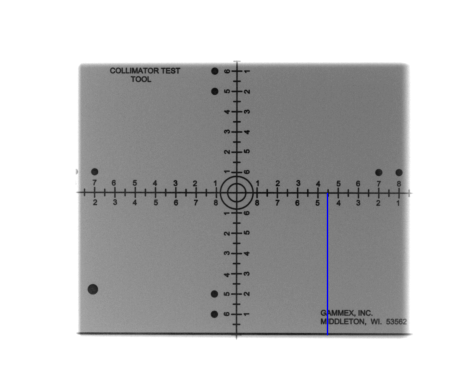

In [83]:
center_p = (xpoints[1]+xpoints[2])//2, ypoints[1]
bottop_p = (xpoints[1]+xpoints[2])//2, ypoints[2]
draw_line(arr, center_p[0], center_p[1], bottop_p[0], bottop_p[1])

In [84]:
top_left_point = bottop_p[0]-add_vertical_crop, bottop_p[1]-add_horizontal_crop
bottom_right_point = bottop_p[0]+add_vertical_crop, bottop_p[1]+add_horizontal_crop
top_left_point, bottom_right_point

((939, 896), (1029, 1120))

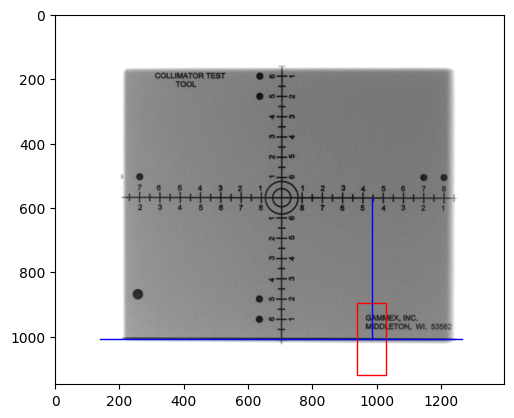

In [85]:
ax = plt.gca()
display(arr, True)
(x, y), w, h = top_left_point, bottom_right_point[0]-top_left_point[0], bottom_right_point[1]-top_left_point[1]
plt.plot([xpoints[0], xpoints[2]], [ypoints[2], ypoints[2]], color='blue', linewidth=1)
plt.plot([center_p[0], bottop_p[0]], [center_p[1], bottop_p[1]], color='blue', linewidth=1)
rect = Rectangle((x, y), w, h, linewidth=1, edgecolor='r',facecolor='none')
ax.add_patch(rect)

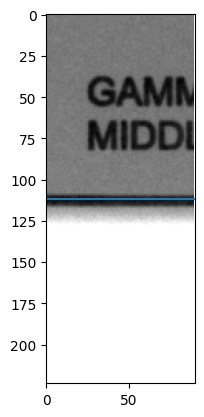

In [86]:
bottop_focus = arr[top_left_point[1]: bottom_right_point[1], top_left_point[0]: bottom_right_point[0]]
display(bottop_focus, True)
plt.plot([0, bottom_right_point[0]-top_left_point[0]], [ypoints[2]-top_left_point[1], ypoints[2]-top_left_point[1]])
plt.xlim([0, bottom_right_point[0]-top_left_point[0]]);

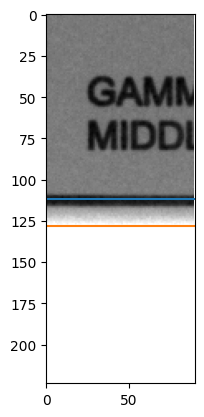

In [87]:
first_white_bottom = first_white(bottop_focus, by_col=False,  position="bottom")
display(bottop_focus, True)
plt.plot([0, bottom_right_point[0]-top_left_point[0]], [ypoints[2]-top_left_point[1], ypoints[2]-top_left_point[1]])
plt.plot([0, bottom_right_point[0]-top_left_point[0]], [first_white_bottom, first_white_bottom])
plt.xlim([0, bottom_right_point[0]-top_left_point[0]]);

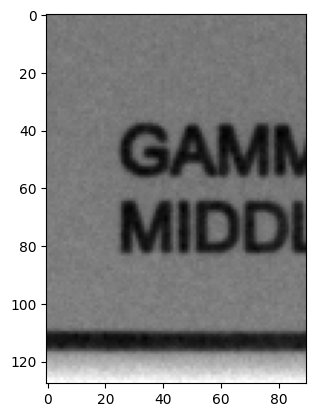

In [88]:
bottom_find_black = bottop_focus[:first_white_bottom, :]
display(bottom_find_black, True)

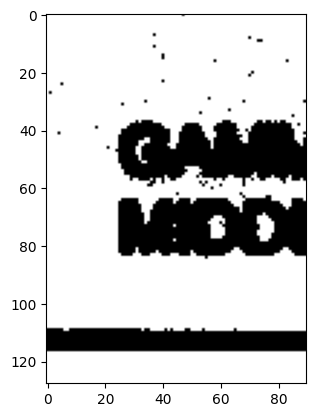

In [89]:
cut_off = bottom_find_black.mean()
binary_arr = (bottom_find_black > cut_off)*1
display(binary_arr, True)

In [90]:
last_white_bottom = first_white(binary_arr, by_col=False,  position="bottom")
first_white_top, last_white_bottom

(144, 117)

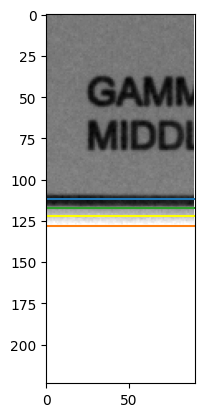

In [91]:
display(bottop_focus, True)
plt.plot([0, bottom_right_point[0]-top_left_point[0]], [ypoints[2]-top_left_point[1], ypoints[2]-top_left_point[1]])
plt.plot([0, bottom_right_point[0]-top_left_point[0]], [first_white_bottom, first_white_bottom])
plt.plot([0, bottom_right_point[0]-top_left_point[0]], [last_white_bottom, last_white_bottom])
plt.xlim([0, bottom_right_point[0]-top_left_point[0]]);
bte_pos = (first_white_bottom + last_white_bottom) //2
plt.plot([0, bottom_right_point[0]-top_left_point[0]], [bte_pos, bte_pos], c="yellow")

In [92]:
bte_pos = bte_pos + top_left_point[1] # to reset position same as large arr

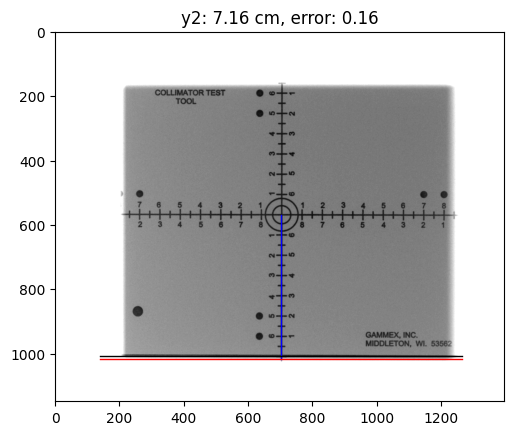

In [93]:
draw_line(arr, xpoints[1], bte_pos, xpoints[1], ypoints[1], True)
plt.plot([xpoints[0], xpoints[2]], [ypoints[2], ypoints[2]], color='k', linewidth=1)
plt.plot([xpoints[0], xpoints[2]], [bte_pos, bte_pos], color='red', linewidth=1)
length_y2 = pixel2cm(bte_pos-ypoints[1], is_rotate)
legth_diff = pixel2cm((bte_pos-ypoints[1]) - (ypoints[2]-ypoints[1]), is_rotate)
plt.title(f"y2: {length_y2:.2f} cm, error: {legth_diff:.2f}");

In [94]:
res.append([xpoints[0], xpoints[2], bte_pos, bte_pos, length_y2, legth_diff])

## Result

In [95]:
res
# left, right, top, bottom
# x1, x2, y1, y2, length, err

[[214, 214, 132, 1008, 7.82, -1.18],
 [1232, 1232, 132, 1008, 8.45, -0.54],
 [140, 1266, 171, 171, 6.38, -0.62],
 [140, 1266, 1018, 1018, 7.16, 0.16]]

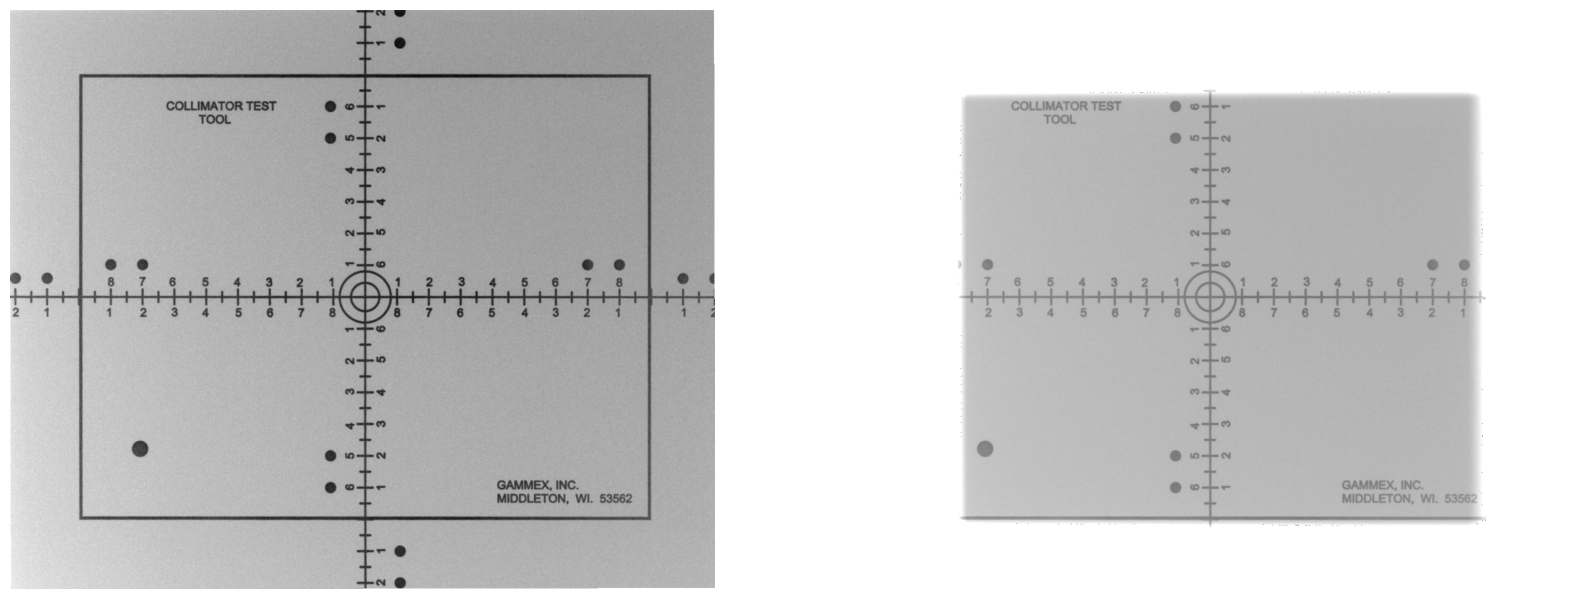

In [96]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
display(arrays[0])

plt.subplot(1, 2, 2)
display(arrays[1])

In [97]:
arr1 = arrays[0].astype(np.uint16) # for not add overflow
arr2 = arrays[1].astype(np.uint16) 
add_arr = arr1 + arr2
add_arr = (add_arr/add_arr.max())*255
add_arr = add_arr.astype(np.uint8)

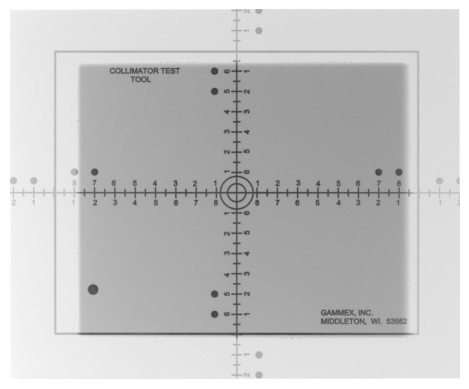

In [98]:
display(add_arr)

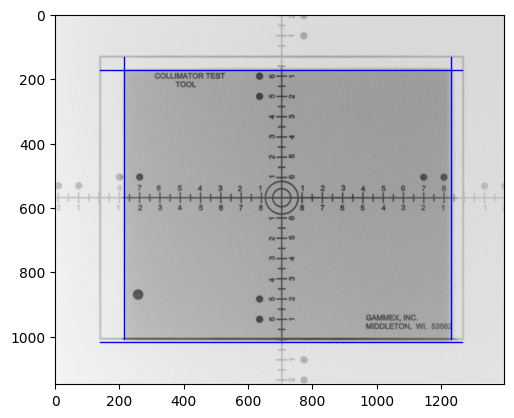

In [99]:
display(add_arr, True)
for x1, x2, y1, y2, length, err in res :
    plt.plot([x1, x2], [y1, y2], color='blue', linewidth=1)

In [100]:
# adjust for correct small rectangle
res[0][2] = res[2][2] # left(y1) -> top(y1)
res[0][3] = res[3][2] # left(y2) -> bottom(y1)
res[1][2] = res[2][2] # right(y1) -> top(y1)
res[1][3] = res[3][2] # rigth(y2) -> bottom(y1)
res[2][0] = res[0][0] # top(x1) -> left(x1)
res[2][1] = res[1][0] # top(x2) -> right(x1)
res[3][0] = res[0][0] # bottom(x1) -> left(x1)
res[3][1] = res[1][0] # bottom(x2) -> right(x1)

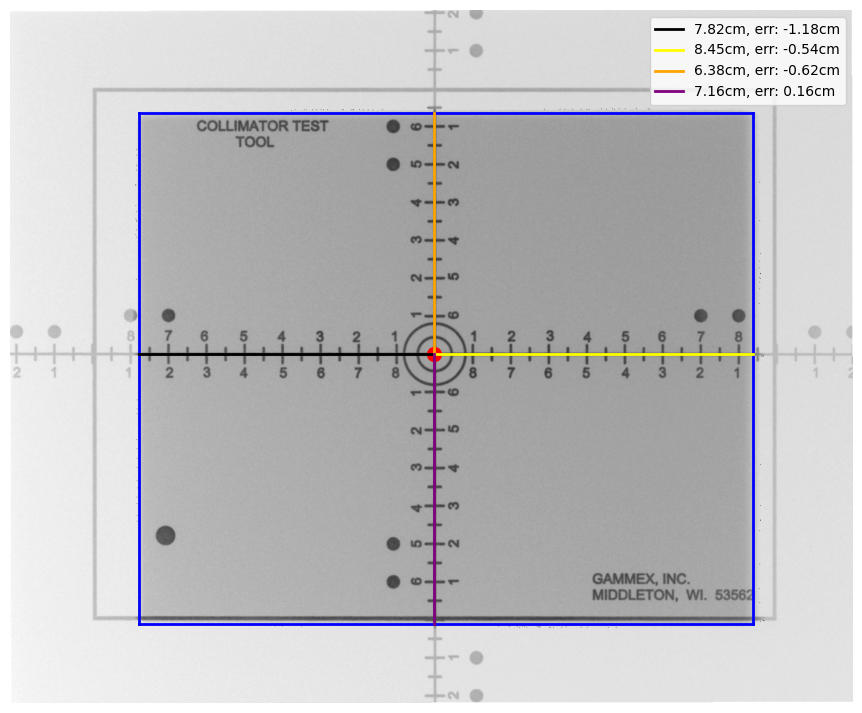

In [112]:
plt.figure(figsize=(15, 9))
plt.imshow(add_arr, cmap="gray")
colors = ["k", "yellow", "orange", "purple"]
center = xpoints[1], ypoints[1]
for idx, (x1, x2, y1, y2, length, err) in enumerate(res) :
    plt.plot([x1, x2], [y1, y2], color='blue', linewidth=2)
    if idx < 2 : point = x1, ypoints[1]
    else : point = xpoints[1], y1
    plt.plot([point[0], center[0]], [point[1], center_p[1]], color=colors[idx], linewidth=2, label=f"{length:.2f}cm, err: {err:.2f}cm")
plt.scatter([center[0]], [center[1]], c="red", s=100)
plt.legend()
plt.axis(False);